In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, Activation, Reshape, Concatenate, BatchNormalization, LayerNormalization, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
import os

In [2]:
base_path = r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\Smart Cities\Project"

In [3]:
image_size=(26,41)
batch_size=26

In [4]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    base_path + r"\Dataset\Final Dataset\Train\Images",
    color_mode='grayscale',
    image_size=image_size,
    batch_size=128,
    shuffle=True,
)

Found 248797 files belonging to 37 classes.


In [5]:
test_dataset=tf.keras.utils.image_dataset_from_directory(
    base_path + r"\Dataset\Final Dataset\Test\Images",
    color_mode='grayscale',
    image_size=image_size,
    batch_size=128,
    shuffle=True,
)

Found 62181 files belonging to 37 classes.


In [6]:
def CNN_model():
    initializers=tf.keras.initializers.RandomNormal(seed=1)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(26,41,1)),
        tf.keras.layers.Conv2D(16,kernel_size=(1,3),strides=(1,1),padding="same",kernel_initializer=initializers),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(16,kernel_size=(1,3),strides=(1,1),padding="same",kernel_initializer=initializers),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(16,kernel_size=(1,3),strides=(1,1),padding="same",kernel_initializer=initializers),
    ])

    return model

In [7]:
def LSTM_model(input_shape=(26,41,16),n_a=512,n_h=8,n_values=37, context_window=26):

    # Kernel Initializer
    initializers = tf.keras.initializers.RandomNormal(seed=1)
    # Reshapers
    reshaper_input = Reshape((1,input_shape[1]*input_shape[2]))
    reshaper_temporal = Reshape((1,n_a//4))
    reshaper_output = Reshape((input_shape[0]*n_a//4,))
    # Dense Cells
    Densor1 = Dense(n_a/2, kernel_initializer=initializers, activation="relu")
    Densor2 = Dense(n_a/4,kernel_initializer=initializers,activation="relu")
    # Self Attention Mechanism
    key = Dense(n_a/4,kernel_initializer=initializers,activation="relu")
    query = Dense(n_a/4,kernel_initializer=initializers,activation="relu")
    value = Dense(n_a/4,kernel_initializer=initializers,activation="relu")
    # Concatenate temporal outputs 
    reshape = Reshape((input_shape[0], input_shape[1] * (n_a // 4)))
    # Softmax to obtain prediction
    Densor_softmax = Dense(n_values, kernel_initializer=initializers, activation='linear')

    # Model Architecture
    inputs = Input(shape=input_shape)
    
    outputs = Densor1(inputs)
    outputs = Densor2(outputs)
    
    # Concatenate temporal dimension
    print(outputs.shape)
    outputs = reshape(outputs)
    # Embedding Dimension for each head
    n_dk = (n_a//4)//n_h
    sqrt_dk = tf.math.sqrt(tf.cast(n_dk,tf.float32))
    # Multi Head Self Attention
    q = query(outputs)
    q = Reshape((input_shape[0],n_h,n_dk))(q)
    q = tf.transpose(q,perm=[0,2,1,3])
    k = key(outputs)
    k = Reshape((input_shape[0],n_h,n_dk))(k)
    k = tf.transpose(k,perm=[0,2,3,1])
    v = value(outputs)
    v = Reshape((input_shape[0],n_h,n_dk))(v)
    v = tf.transpose(v,perm=[0,2,1,3])
    self_attention_scores = tf.nn.softmax(tf.matmul(q,k)/sqrt_dk,axis=-1)
    self_attention = tf.matmul(self_attention_scores,v)
    self_attention = tf.transpose(self_attention,perm=[0,2,1,3])
    self_attention = Reshape((input_shape[0],n_a//4))(self_attention)
    # Output reshape
    outputs = reshaper_output(self_attention)
    # Feed Forward Network
    outputs = Dense(n_a//4,kernel_initializer=initializers,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01))(outputs)
    # Softmax output
    outputs = Densor_softmax(outputs)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [8]:
def CNN_LSTM_model():
    input = Input(shape=(26,41,1))
    x = CNN_model()(input)
    output = LSTM_model((26,41,16),512,8,37,26)(x)
    
    model = Model(inputs=[input],outputs=[output])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    return model

In [9]:
model = CNN_LSTM_model()

(None, 26, 41, 128)


In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 41, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 26, 41, 16)        1632      
                                                                 
 model (Functional)          (None, 37)                2483749   
                                                                 
Total params: 2,485,381
Trainable params: 2,485,381
Non-trainable params: 0
_________________________________________________________________


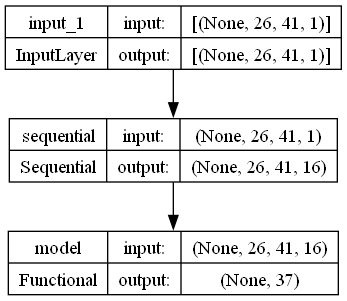

In [12]:
tf.keras.utils.plot_model(model,to_file= base_path + "/Results/CNN_DNN_ATTENTION/Softmax_CNN_ATTENTION_model.png",show_shapes=True)

In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.prev_loss=0
    def on_epoch_end(self,epoch,logs={}):
        model.save(base_path + f"/Results/CNN_DNN_ATTENTION/model_{epoch}.h5")
        if(epoch>0 and logs.get('loss')>=self.prev_loss):
            print('\nLearning rate updated')
            self.model.optimizer.lr.assign(self.model.optimizer.lr.read_value()*0.1)
        self.prev_loss=logs.get('loss')

callbacks=myCallback()

In [15]:
history=model.fit(train_dataset,validation_data=test_dataset,batch_size=128,epochs=5,callbacks=[callbacks])

Epoch 1/5


1944/1944 [==============================] - 207s 106ms/step - loss: 2.9340 - accuracy: 0.9046 - val_loss: 0.6507 - val_accuracy: 0.9588
Epoch 2/5
1944/1944 [==============================] - 206s 106ms/step - loss: 0.3568 - accuracy: 0.9634 - val_loss: 0.1993 - val_accuracy: 0.9642
Epoch 3/5
1944/1944 [==============================] - 207s 106ms/step - loss: 0.1471 - accuracy: 0.9662 - val_loss: 0.1170 - val_accuracy: 0.9647
Epoch 4/5
1944/1944 [==============================] - 205s 105ms/step - loss: 0.1003 - accuracy: 0.9677 - val_loss: 0.0944 - val_accuracy: 0.9664
Epoch 5/5
1944/1944 [==============================] - 204s 105ms/step - loss: 0.0868 - accuracy: 0.9688 - val_loss: 0.0898 - val_accuracy: 0.9651


In [16]:
# Emergency Save
model.save(base_path + f"/Results/CNN_DNN_ATTENTION/model_{5}.h5")

In [17]:
import json

with open(base_path + f"/Results/CNN_DNN_ATTENTION.txt","w") as file:
    file.write(json.dumps(history.params))
with open(base_path + f"/Results/CNN_DNN_ATTENTION_history.txt","w") as file:
    file.write(json.dumps(history.history))

In [18]:
model=tf.keras.models.load_model(base_path + f"/Results/CNN_DNN_ATTENTION/model_{5}.h5")

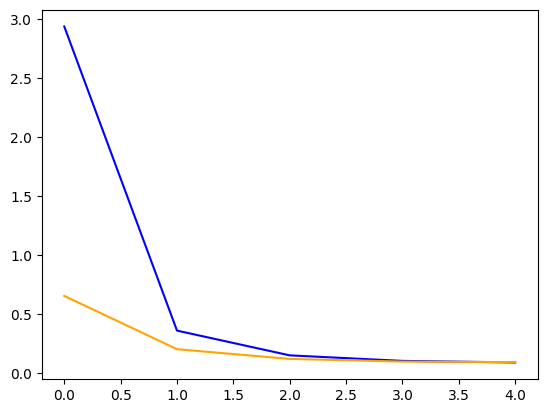

In [19]:
plt.plot(range(5),history.history["loss"],color="blue",label="Train Loss")
plt.plot(range(5),history.history["val_loss"],color="orange",label="Validation Loss")
plt.show()

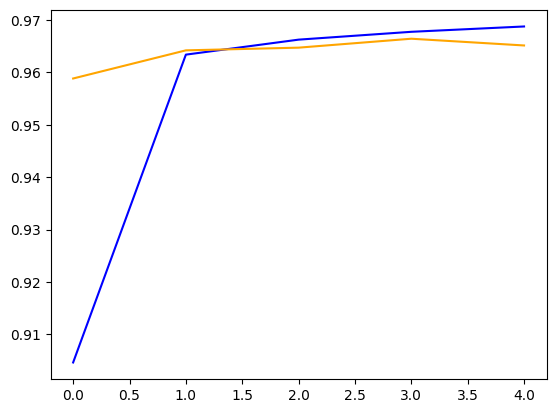

In [20]:
plt.plot(range(5),history.history["accuracy"],color="blue",label="Train Accuracy")
plt.plot(range(5),history.history["val_accuracy"],color="orange",label="Validation Accuracy")
plt.show()

In [21]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have a trained model `model`
# context_window: The target image size (e.g., (26, 41)) for resizing images

# Load the train dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    base_path + r"\Dataset\Final Dataset\Train\Images",
    color_mode='grayscale',
    image_size=image_size,
    batch_size=128,
    shuffle=True,
)

# Prepare for evaluation metrics
predictions = []
true_labels = []

# Loop over the train dataset in batches
for images, labels in train_dataset:
    # Predict for the current batch
    batch_predictions = model.predict(images, verbose=0)  # Using the trained model
    
    # Append the batch predictions and true labels
    predictions.append(batch_predictions)
    true_labels.append(labels)

# Concatenate all batch predictions and true labels
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# If you have multi-class classification and the output is one-hot encoded:
# You may need to convert to single class predictions
predictions = np.argmax(predictions, axis=-1)  # Convert to class index (max prob)

# Evaluate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')  # or 'micro' depending on your use case
recall = recall_score(true_labels, predictions, average='weighted')  # or 'micro'
f1_score_value = f1_score(true_labels, predictions, average='weighted')  # or 'micro'

# Print the metrics
print(f"Train Accuracy: {accuracy * 100:.2f}%")
print(f"Train Precision: {precision * 100:.2f}%")
print(f"Train Recall: {recall * 100:.2f}%")
print(f"Train F1-Score: {f1_score_value * 100:.2f}%")

Found 248797 files belonging to 37 classes.


c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 97.20%
Train Precision: 97.10%
Train Recall: 97.20%
Train F1-Score: 97.12%


In [22]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have a trained model `model`
# context_window: The target image size (e.g., (26, 41)) for resizing images

# Load the test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    base_path + r"\Dataset\Final Dataset\Test\Images",
    color_mode='grayscale',
    image_size=image_size,
    batch_size=128,
    shuffle=True,
)

# Prepare for evaluation metrics
predictions = []
true_labels = []

# Loop over the test dataset in batches
for images, labels in test_dataset:
    # Predict for the current batch
    batch_predictions = model.predict(images, verbose=0)  # Using the trained model
    
    # Append the batch predictions and true labels
    predictions.append(batch_predictions)
    true_labels.append(labels)

# Concatenate all batch predictions and true labels
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# If you have multi-class classification and the output is one-hot encoded:
# You may need to convert to single class predictions
predictions = np.argmax(predictions, axis=-1)  # Convert to class index (max prob)

# Evaluate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')  # or 'micro' depending on your use case
recall = recall_score(true_labels, predictions, average='weighted')  # or 'micro'
f1_score_value = f1_score(true_labels, predictions, average='weighted')  # or 'micro'

# Print the metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1_score_value * 100:.2f}%")

Found 62181 files belonging to 37 classes.
Accuracy: 96.51%
Precision: 96.51%
Recall: 96.51%
F1-Score: 96.46%


c:\Users\Sagar\anaconda3\envs\py39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
